In [ ]:
!pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.8 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=7bfd00c531a253eec6ded9579f41298ac2a00fdbacb4a8b70afb9f07e9ba9fd7
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
print(healthy_autocrine.obs['disease'].unique())

['normal']
Categories (1, object): ['normal']


In [ ]:
print(diseased_autocrine.obs['disease'].unique())

['normal', 'tumor']
Categories (2, object): ['normal', 'tumor']


In [ ]:
print(healthy_paracrine)

AnnData object with n_obs × n_vars = 2224 × 20138
    obs: 'domain.type', 'disease', 'imagerow', 'imagecol', 'SEMA3G_NRP2_binary_labels'
    var: 'n_cells'
    uns: 'SEMA3G_NRP2_binary_labels_colors', 'lr_summary', 'lrfeatures', 'spatial'
    obsm: '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'position', 'spatial', 'spot_neigh_bcs', 'spot_neighbours'


In [ ]:
print(diseased_paracrine)

AnnData object with n_obs × n_vars = 467 × 12876
    obs: 'domain.type', 'disease', 'imagerow', 'imagecol', 'MCAM_MCAM_binary_labels'
    var: 'n_cells'
    uns: 'MCAM_MCAM_binary_labels_colors', 'disease_colors', 'domain.type_colors', 'lr_summary', 'lrfeatures', 'spatial'
    obsm: '-log10(p_adjs)', 'lr_scores', 'lr_sig_scores', 'p_adjs', 'p_vals', 'position', 'spatial', 'spot_neigh_bcs', 'spot_neighbours'


GAN autocrine

In [ ]:
# Import required libraries
import scanpy as sc
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Load the autocrine .h5ad files
healthy_autocrine = sc.read_h5ad('cell_cell_communication_healthy_autocrine.h5ad')
diseased_autocrine = sc.read_h5ad('cell_cell_communication_unhealthy_autocrine.h5ad')

# Extract the cell-cell communication scores
healthy_autocrine_scores = healthy_autocrine.obsm['lr_scores']  # Adjust if scores are stored elsewhere
diseased_autocrine_scores = diseased_autocrine.obsm['lr_scores']

# Ensure the feature dimensions match by padding or truncating
max_features = max(healthy_autocrine_scores.shape[1], diseased_autocrine_scores.shape[1])

# Pad healthy_autocrine_scores if needed
if healthy_autocrine_scores.shape[1] < max_features:
    padding = max_features - healthy_autocrine_scores.shape[1]
    healthy_autocrine_scores = np.pad(healthy_autocrine_scores, ((0, 0), (0, padding)), mode='constant')

# Pad diseased_autocrine_scores if needed
if diseased_autocrine_scores.shape[1] < max_features:
    padding = max_features - diseased_autocrine_scores.shape[1]
    diseased_autocrine_scores = np.pad(diseased_autocrine_scores, ((0, 0), (0, padding)), mode='constant')

# Prepare data
X_train = healthy_autocrine_scores
X_test = diseased_autocrine_scores

print("Healthy Autocrine Training Data Shape:", X_train.shape)
print("Diseased Autocrine Testing Data Shape:", X_test.shape)

# Define Generator Class
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define Discriminator Class
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 64
lr = 0.0002
epochs = 500
batch_size = 16
patience = 10

# Data loader for training
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)

# Initialize models
generator = Generator(input_dim, hidden_dim)
discriminator = Discriminator(input_dim, hidden_dim)
criterion = nn.BCELoss()
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop with early stopping
best_g_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    for real_data, in train_loader:
        batch_size = real_data.size(0)

        # Discriminator Training
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        outputs = discriminator(real_data)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, input_dim)
        fake_data = generator(z)
        outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optim_d.zero_grad()
        d_loss.backward()
        optim_d.step()

        # Generator Training
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)

        optim_g.zero_grad()
        g_loss.backward()
        optim_g.step()

    # Early stopping
    if g_loss < best_g_loss:
        best_g_loss = g_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

# Evaluate on diseased data
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
anomaly_scores = []

with torch.no_grad():
    for test_data, in test_loader:
        z = torch.randn(test_data.size(0), input_dim)
        generated_data = generator(z)
        error = torch.norm(test_data - generated_data, p=2, dim=1).cpu().numpy()
        anomaly_scores.extend(error)

# Define threshold for anomalies
threshold = np.percentile(anomaly_scores, 60)

# Identify anomalous spots
anomalous_spots = [i for i, score in enumerate(anomaly_scores) if score > threshold]
print("Anomalous spots:", anomalous_spots)

# # Evaluation
true_labels = diseased_autocrine.obs['disease'].map({'normal': 0, 'tumor': 1}).astype(int)
pred_labels = [1 if score > threshold else 0 for score in anomaly_scores]

precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, anomaly_scores)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {roc_auc:.4f}")


Healthy Autocrine Training Data Shape: (2224, 335)
Diseased Autocrine Testing Data Shape: (467, 335)
Epoch [0/500], d_loss: 1.3961408138275146, g_loss: 0.6955476999282837
Epoch [50/500], d_loss: 1.3863022327423096, g_loss: 0.6931431889533997
Early stopping at epoch 63
Anomalous spots: [2, 7, 8, 16, 20, 21, 24, 25, 26, 32, 50, 51, 52, 53, 54, 69, 75, 77, 78, 80, 81, 82, 92, 96, 97, 104, 105, 107, 109, 110, 111, 117, 122, 123, 127, 128, 129, 130, 134, 136, 143, 145, 147, 148, 149, 150, 153, 154, 157, 162, 163, 164, 165, 166, 167, 168, 169, 170, 176, 177, 178, 180, 183, 184, 185, 187, 188, 189, 190, 194, 198, 200, 201, 204, 205, 206, 210, 211, 218, 219, 227, 230, 231, 233, 234, 235, 237, 239, 249, 250, 251, 253, 254, 255, 256, 257, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 275, 276, 281, 285, 287, 292, 293, 295, 298, 303, 304, 305, 306, 307, 312, 315, 316, 317, 318, 319, 320, 321, 326, 327, 329, 330, 331, 332, 333, 335, 337, 338, 340, 342, 343, 344, 345, 346, 348, 349, 351, 352, 3

In [ ]:
pathway = sc.read("pathway_filtered_Breast_full_ref1.h5ad")

In [ ]:
print(pathway)

AnnData object with n_obs × n_vars = 3037 × 14
    obs: 'domain.type', 'disease', 'n_genes', 'percent_mito', 'n_counts'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'spatial'
    obsm: 'X_pca', 'mlm_estimate', 'mlm_pvals', 'position', 'progeny_mlm_estimate', 'progeny_mlm_pvals', 'spatial'


In [ ]:
pathway1 = sc.read("pathway_filtered_Breast_full_tumor.h5ad")

In [ ]:
print(pathway1)

AnnData object with n_obs × n_vars = 467 × 14
    obs: 'domain.type', 'disease', 'n_genes', 'percent_mito', 'n_counts'
    uns: 'disease_colors', 'domain.type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial'
    obsm: 'X_pca', 'mlm_estimate', 'mlm_pvals', 'position', 'progeny_mlm_estimate', 'progeny_mlm_pvals', 'spatial'


GAN Pathway

In [ ]:
# Import required libraries
import scanpy as sc
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Load the pathway AnnData files
healthy_pathway = sc.read_h5ad('pathway_filtered_Breast_full_ref1.h5ad')
diseased_pathway = sc.read_h5ad('pathway_filtered_Breast_full_tumor.h5ad')

# Extract the pathway features
healthy_pathway_features = healthy_pathway.obsm['progeny_mlm_estimate']
diseased_pathway_features = diseased_pathway.obsm['progeny_mlm_estimate']

# Verify the feature shapes
print("Healthy Pathway Features Shape:", healthy_pathway_features.shape)
print("Diseased Pathway Features Shape:", diseased_pathway_features.shape)

# Prepare data
X_train = healthy_pathway_features
X_test = diseased_pathway_features

print("Training Data Shape (Healthy):", X_train.shape)
print("Testing Data Shape (Diseased):", X_test.shape)

# Define Generator Class
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define Discriminator Class
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 64
lr = 0.0002
epochs = 500
batch_size = 16
patience = 10

# Ensure X_train and X_test are NumPy arrays
X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test

# Create the data loader for training
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)


# Initialize models
generator = Generator(input_dim, hidden_dim)
discriminator = Discriminator(input_dim, hidden_dim)
criterion = nn.BCELoss()
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop with early stopping
best_g_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    for real_data, in train_loader:
        batch_size = real_data.size(0)

        # Discriminator Training
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        outputs = discriminator(real_data)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, input_dim)
        fake_data = generator(z)
        outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optim_d.zero_grad()
        d_loss.backward()
        optim_d.step()

        # Generator Training
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)

        optim_g.zero_grad()
        g_loss.backward()
        optim_g.step()

    # Early stopping
    if g_loss < best_g_loss:
        best_g_loss = g_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

# Evaluate on diseased data
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
anomaly_scores = []

with torch.no_grad():
    for test_data, in test_loader:
        z = torch.randn(test_data.size(0), input_dim)
        generated_data = generator(z)
        error = torch.norm(test_data - generated_data, p=2, dim=1).cpu().numpy()
        anomaly_scores.extend(error)

# Define threshold for anomalies
threshold = np.percentile(anomaly_scores, 70)

# Identify anomalous spots
anomalous_spots = [i for i, score in enumerate(anomaly_scores) if score > threshold]
print("Anomalous spots:", anomalous_spots)

# Evaluation
true_labels = diseased_pathway.obs['disease'].map({'normal': 0, 'tumor': 1}).astype(int)
pred_labels = [1 if score > threshold else 0 for score in anomaly_scores]

precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, anomaly_scores)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {roc_auc:.4f}")


Healthy Pathway Features Shape: (3037, 14)
Diseased Pathway Features Shape: (467, 14)
Training Data Shape (Healthy): (3037, 14)
Testing Data Shape (Diseased): (467, 14)
Epoch [0/500], d_loss: 1.392894983291626, g_loss: 0.6961605548858643
Early stopping at epoch 41
Anomalous spots: [1, 5, 7, 17, 18, 20, 30, 33, 37, 39, 41, 44, 51, 52, 56, 57, 58, 60, 62, 66, 68, 69, 72, 75, 77, 78, 87, 88, 89, 92, 95, 96, 97, 98, 99, 106, 107, 108, 114, 115, 116, 122, 124, 128, 130, 131, 134, 136, 137, 138, 141, 144, 145, 152, 153, 154, 156, 157, 165, 174, 181, 185, 196, 198, 200, 202, 204, 205, 207, 208, 210, 217, 218, 229, 230, 232, 241, 243, 248, 250, 254, 257, 258, 267, 268, 274, 281, 287, 288, 290, 294, 296, 298, 301, 306, 312, 319, 343, 350, 351, 355, 358, 359, 365, 366, 369, 376, 377, 381, 382, 384, 386, 388, 393, 395, 396, 398, 399, 402, 403, 409, 411, 415, 416, 418, 419, 420, 422, 426, 427, 428, 432, 440, 445, 448, 449, 450, 453, 456, 459]
Precision: 0.3714
Recall: 0.3250
F1 Score: 0.3467
AUC S

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


GAN Pancriactic



Healthy Autocrine Training Data Shape: (2224, 579)
Diseased Autocrine Testing Data Shape: (467, 579)
Epoch [0/500], d_loss: 1.3931570053100586, g_loss: 0.6962036490440369
Early stopping at epoch 48
Anomalous spots: [1, 2, 6, 7, 8, 15, 20, 24, 25, 26, 32, 42, 43, 50, 51, 52, 54, 56, 60, 62, 63, 69, 70, 71, 76, 77, 80, 81, 82, 84, 85, 89, 96, 97, 103, 104, 105, 107, 108, 109, 110, 111, 115, 117, 122, 123, 127, 128, 129, 130, 134, 136, 143, 145, 146, 147, 148, 149, 150, 153, 154, 155, 157, 162, 163, 164, 165, 166, 167, 168, 169, 170, 176, 177, 178, 183, 184, 185, 187, 188, 189, 190, 191, 192, 198, 199, 200, 201, 204, 205, 206, 207, 210, 211, 212, 219, 220, 227, 229, 230, 231, 232, 233, 234, 235, 239, 244, 245, 247, 248, 249, 250, 251, 252, 253, 254, 255, 257, 258, 259, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 275, 276, 281, 284, 285, 286, 287, 288, 289, 291, 292, 293, 295, 298, 302, 303, 304, 305, 306, 307, 308, 312, 315, 316, 317, 318, 319, 320, 321, 322, 323, 326, 327, 328, 329

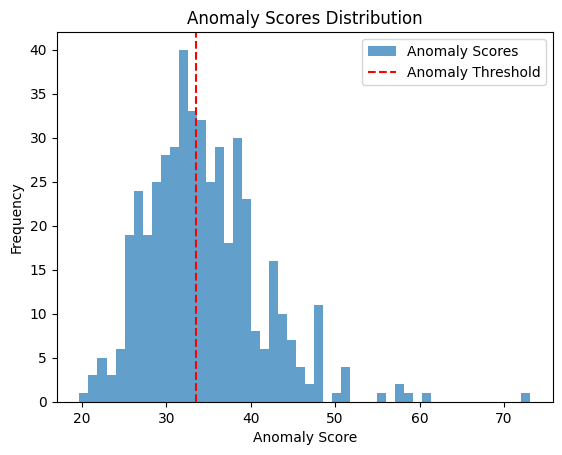

In [ ]:
# Import required libraries
import scanpy as sc
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Load the autocrine .h5ad files
healthy_autocrine = sc.read_h5ad('cell_cell_communication_healthy_pancriatic.h5ad')
diseased_autocrine = sc.read_h5ad('cell_cell_communication_unhealthy_pancriatic.h5ad')

# Extract the cell-cell communication scores
healthy_autocrine_scores = healthy_autocrine.obsm['lr_scores']  # Adjust if scores are stored elsewhere
diseased_autocrine_scores = diseased_autocrine.obsm['lr_scores']

# Ensure the feature dimensions match by padding or truncating
max_features = max(healthy_autocrine_scores.shape[1], diseased_autocrine_scores.shape[1])

# Pad healthy_autocrine_scores if needed
if healthy_autocrine_scores.shape[1] < max_features:
    padding = max_features - healthy_autocrine_scores.shape[1]
    healthy_autocrine_scores = np.pad(healthy_autocrine_scores, ((0, 0), (0, padding)), mode='constant')

# Pad diseased_autocrine_scores if needed
if diseased_autocrine_scores.shape[1] < max_features:
    padding = max_features - diseased_autocrine_scores.shape[1]
    diseased_autocrine_scores = np.pad(diseased_autocrine_scores, ((0, 0), (0, padding)), mode='constant')

# Prepare data
X_train = healthy_autocrine_scores
X_test = diseased_autocrine_scores

print("Healthy Autocrine Training Data Shape:", X_train.shape)
print("Diseased Autocrine Testing Data Shape:", X_test.shape)

# Define Generator Class
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define Discriminator Class
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 64
lr = 0.0002
epochs = 500
batch_size = 16
patience = 10

# Data loader for training
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)

# Initialize models
generator = Generator(input_dim, hidden_dim)
discriminator = Discriminator(input_dim, hidden_dim)
criterion = nn.BCELoss()
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop with early stopping
best_g_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    for real_data, in train_loader:
        batch_size = real_data.size(0)

        # Discriminator Training
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        outputs = discriminator(real_data)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, input_dim)
        fake_data = generator(z)
        outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        optim_d.zero_grad()
        d_loss.backward()
        optim_d.step()

        # Generator Training
        outputs = discriminator(fake_data)
        g_loss = criterion(outputs, real_labels)

        optim_g.zero_grad()
        g_loss.backward()
        optim_g.step()

    # Early stopping
    if g_loss < best_g_loss:
        best_g_loss = g_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

# Evaluate on diseased data
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
anomaly_scores = []

with torch.no_grad():
    for test_data, in test_loader:
        z = torch.randn(test_data.size(0), input_dim)
        generated_data = generator(z)
        error = torch.norm(test_data - generated_data, p=2, dim=1).cpu().numpy()
        anomaly_scores.extend(error)

# Define threshold for anomalies
threshold = np.percentile(anomaly_scores, 50)

# Identify anomalous spots
anomalous_spots = [i for i, score in enumerate(anomaly_scores) if score > threshold]
print("Anomalous spots:", anomalous_spots)

# # Optimized threshold selection
# fpr, tpr, roc_thresholds = roc_curve(diseased_autocrine.obs['disease'].map({'normal': 0, 'tumor': 1}), anomaly_scores)
# optimal_idx = np.argmax(tpr - fpr)
# threshold = roc_thresholds[optimal_idx]
# print(f"Optimal Threshold: {threshold}")

# # Evaluation
true_labels = diseased_autocrine.obs['disease'].map({'normal': 0, 'tumor': 1}).astype(int)
pred_labels = [1 if score > threshold else 0 for score in anomaly_scores]
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, anomaly_scores)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {roc_auc:.4f}")

# Visualization of anomaly scores
plt.hist(anomaly_scores, bins=50, alpha=0.7, label='Anomaly Scores')
plt.axvline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Anomaly Scores Distribution')
plt.legend()
plt.show()




GAN Modified

Epoch [0/700], d_loss: 9.578075408935547, g_loss: 0.76084303855896
Epoch [50/700], d_loss: 4.248492240905762, g_loss: 0.8440604209899902
Epoch [100/700], d_loss: 4.293643951416016, g_loss: 0.7560501098632812
Epoch [150/700], d_loss: 4.531435012817383, g_loss: 0.7716168165206909
Epoch [200/700], d_loss: 3.7810721397399902, g_loss: 0.8203563690185547
Early stopping at epoch 222
Anomalous spots: [8, 25, 51, 60, 69, 109, 128, 129, 130, 136, 143, 148, 149, 163, 166, 167, 168, 169, 170, 183, 184, 185, 187, 189, 190, 200, 205, 206, 210, 211, 233, 234, 235, 250, 251, 252, 253, 254, 264, 265, 269, 270, 271, 281, 287, 292, 298, 303, 304, 306, 307, 312, 315, 317, 318, 319, 320, 321, 326, 327, 330, 331, 333, 337, 342, 343, 344, 345, 346, 349, 352, 353, 357, 358, 361, 362, 369, 372, 373, 374, 375, 377, 384, 385, 386, 388, 395, 398, 399, 400, 401, 410, 439, 440]
Precision: 0.6383
Recall: 0.3750
F1 Score: 0.4724
AUC Score: 0.7548


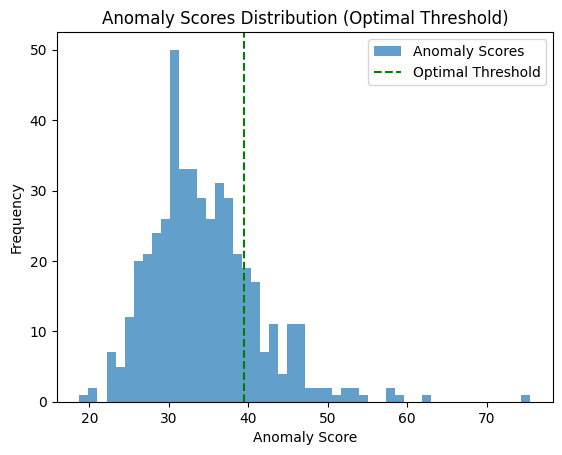

In [ ]:
# Import required libraries
import scanpy as sc
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Load the autocrine .h5ad files
healthy_autocrine = sc.read_h5ad('cell_cell_communication_healthy_pancriatic.h5ad')
diseased_autocrine = sc.read_h5ad('cell_cell_communication_unhealthy_pancriatic.h5ad')

# Extract the cell-cell communication scores
healthy_autocrine_scores = healthy_autocrine.obsm['lr_scores']  # Adjust if scores are stored elsewhere
diseased_autocrine_scores = diseased_autocrine.obsm['lr_scores']

# Ensure the feature dimensions match by padding or truncating
max_features = max(healthy_autocrine_scores.shape[1], diseased_autocrine_scores.shape[1])

# Pad healthy_autocrine_scores if needed
if healthy_autocrine_scores.shape[1] < max_features:
    padding = max_features - healthy_autocrine_scores.shape[1]
    healthy_autocrine_scores = np.pad(healthy_autocrine_scores, ((0, 0), (0, padding)), mode='constant')

# Pad diseased_autocrine_scores if needed
if diseased_autocrine_scores.shape[1] < max_features:
    padding = max_features - diseased_autocrine_scores.shape[1]
    diseased_autocrine_scores = np.pad(diseased_autocrine_scores, ((0, 0), (0, padding)), mode='constant')

# Prepare data
X_train = healthy_autocrine_scores
X_test = diseased_autocrine_scores

# Define Generator Class
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define Discriminator Class with Gradient Penalty Support
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

    def gradient_penalty(self, real_data, fake_data):
        alpha = torch.rand(real_data.size(0), 1).to(real_data.device)
        interpolates = alpha * real_data + ((1 - alpha) * fake_data)
        interpolates.requires_grad_(True)
        d_interpolates = self(interpolates)
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_interpolates),
            create_graph=True,
            retain_graph=True
        )[0]
        gradients_norm = gradients.view(gradients.size(0), -1).norm(2, dim=1)
        return ((gradients_norm - 1) ** 2).mean()

# Hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 256
lr = 0.0001  # Slightly faster learning rate to accelerate convergence
epochs = 700
batch_size = 32  # Larger batch size
patience = 100  # Increased patience
gp_weight = 12  # Relax gradient penalty slightly





# Data loader for training
train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)

# Initialize models
generator = Generator(input_dim, hidden_dim)
discriminator = Discriminator(input_dim, hidden_dim)
criterion = nn.BCELoss()
optim_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training loop with early stopping
best_g_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    for real_data, in train_loader:
        batch_size = real_data.size(0)

        # Discriminator Training
        real_labels = torch.ones(batch_size, 1, device=real_data.device)
        fake_labels = torch.zeros(batch_size, 1, device=real_data.device)

        outputs_real = discriminator(real_data)
        d_loss_real = criterion(outputs_real, real_labels)

        z = torch.randn(batch_size, input_dim, device=real_data.device)
        fake_data = generator(z)
        outputs_fake = discriminator(fake_data.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)

        gp = discriminator.gradient_penalty(real_data, fake_data)
        d_loss = d_loss_real + d_loss_fake + gp_weight * gp
        optim_d.zero_grad()
        d_loss.backward()
        optim_d.step()

        # Generator Training
        z = torch.randn(batch_size, input_dim, device=real_data.device)
        fake_data = generator(z)
        outputs_fake = discriminator(fake_data)
        g_loss = criterion(outputs_fake, real_labels)

        optim_g.zero_grad()
        g_loss.backward()
        optim_g.step()

    if g_loss.item() < best_g_loss:
        best_g_loss = g_loss.item()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

# Evaluate on diseased data
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
anomaly_scores = []

with torch.no_grad():
    for test_data, in test_loader:
        z = torch.randn(test_data.size(0), input_dim)
        generated_data = generator(z)
        error = torch.norm(test_data - generated_data, p=2, dim=1).cpu().numpy()
        anomaly_scores.extend(error)

# # Optimized threshold selection
# fpr, tpr, roc_thresholds = roc_curve(diseased_autocrine.obs['disease'].map({'normal': 0, 'tumor': 1}), anomaly_scores)
# optimal_idx = np.argmax(tpr - fpr)
# threshold = roc_thresholds[optimal_idx]
# print(f"Optimal Threshold: {threshold}")
# Define threshold for anomalies
threshold = np.percentile(anomaly_scores, 80)

# Identify anomalous spots
anomalous_spots = [i for i, score in enumerate(anomaly_scores) if score > threshold]
print("Anomalous spots:", anomalous_spots)

# Evaluate performance
pred_labels = [1 if score > threshold else 0 for score in anomaly_scores]
true_labels = diseased_autocrine.obs['disease'].map({'normal': 0, 'tumor': 1}).astype(int)

precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, anomaly_scores)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {roc_auc:.4f}")

# Visualization of anomaly scores
plt.hist(anomaly_scores, bins=50, alpha=0.7, label='Anomaly Scores')
plt.axvline(threshold, color='green', linestyle='--', label='Optimal Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Anomaly Scores Distribution (Optimal Threshold)')
plt.legend()
plt.show()


In [ ]:
!pip install dgl

In [ ]:
!pip uninstall dgl torch torchaudio torchvision --y

Found existing installation: dgl 2.4.0
Uninstalling dgl-2.4.0:
  Successfully uninstalled dgl-2.4.0
Found existing installation: torch 2.4.0+cpu
Uninstalling torch-2.4.0+cpu:
  Successfully uninstalled torch-2.4.0+cpu
Found existing installation: torchaudio 2.4.0+cpu
Uninstalling torchaudio-2.4.0+cpu:
  Successfully uninstalled torchaudio-2.4.0+cpu
Found existing installation: torchvision 0.19.0+cpu
Uninstalling torchvision-0.19.0+cpu:
  Successfully uninstalled torchvision-0.19.0+cpu


In [ ]:
!pip install torch==2.4.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.4.0%2Bcpu-cp310-cp310-linux_x86_64.whl (195.0 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.20.1%2Bcpu-cp310-cp310-linux_x86_64.whl (1.8 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchaudio-2.5.1%2Bcpu-cp310-cp310-linux_x86_64.whl (1.7 MB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.20.0%2Bcpu-cp310-cp310-linux_x86_64.whl (1.8 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.19.1%2Bcpu-cp310-cp310-linux_x86_64.whl (1.6 MB)
  Using cached https://download.pytorch.org/whl/cpu/torchvision-0.19.0%2Bcpu-cp310-cp310-linux_x86_64.whl (1.6 MB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requ

In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/repo.html

Looking in links: https://data.dgl.ai/wheels/torch-2.4/repo.html
  Using cached https://data.dgl.ai/wheels/torch-2.4/dgl-2.4.0-cp310-cp310-manylinux1_x86_64.whl (6.8 MB)


GAN STANDS

In [ ]:
import scanpy as sc
import dgl
import torch
import torch.nn as nn
import numpy as np
from sklearn.neighbors import NearestNeighbors
from torch.optim import Adam

# Load the healthy datasets
dataset1 = sc.read_h5ad('/content/drive/MyDrive/CS690 Project/cell_cell_communication_healthy_pancriatic.h5ad')
dataset2 = sc.read_h5ad('/content/drive/MyDrive/CS690 Project/cell_cell_communication_healthy_paracrine_ref2.h5ad')
dataset3 = sc.read_h5ad('/content/drive/MyDrive/CS690 Project/cell_cell_communication_healthy_paracrine_ref3.h5ad')

# Combine the healthy datasets
datasets = [dataset1, dataset2, dataset3]

# Function to preprocess and ensure consistent feature dimensions
def preprocess_features(datasets, max_features):
    for ds in datasets:
        lr_scores = ds.obsm['lr_scores']
        if lr_scores.shape[1] < max_features:
            padding = max_features - lr_scores.shape[1]
            ds.obsm['lr_scores'] = np.pad(lr_scores, ((0, 0), (0, padding)), mode='constant')  # Pad smaller datasets
        elif lr_scores.shape[1] > max_features:
            ds.obsm['lr_scores'] = lr_scores[:, :max_features]  # Truncate larger datasets to the same feature size
    return datasets

# Determine the largest feature dimension
max_features = max([ds.obsm['lr_scores'].shape[1] for ds in datasets])  # Get the largest number of features

# Preprocess the healthy datasets
datasets = preprocess_features(datasets, max_features)

# Function to build a graph from spatial coordinates
def build_graph(lr_scores, spatial_coords, k=5):
    # Build k-NN graph
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(spatial_coords)
    _, indices = nbrs.kneighbors(spatial_coords)
    u = indices[:, 0].repeat(k)  # Repeat the first index k times
    v = indices[:, 1:].flatten()  # Flatten the indices
    graph = dgl.graph((u, v))
    graph = dgl.add_self_loop(graph)  # Add self-loops for stability
    graph.ndata['features'] = torch.tensor(lr_scores, dtype=torch.float32)  # Add LR scores as node features
    return graph

# Create graphs for all healthy datasets
graphs = [
    build_graph(ds.obsm['lr_scores'], ds.obsm['spatial']) for ds in datasets
]

# Merge graphs into a single graph
merged_graph = dgl.batch(graphs)  # Combine all graphs into a single graph

# Define GNN
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = dgl.nn.GraphConv(input_dim, hidden_dim, activation=nn.ReLU())
        self.conv2 = dgl.nn.GraphConv(hidden_dim, output_dim)

    def forward(self, g):
        x = g.ndata['features']  # Get the node features (LR scores)
        x = self.conv1(g, x)  # First GNN layer
        x = self.conv2(g, x)  # Second GNN layer
        return x  # Return the final embeddings

# Define Generator and Discriminator for GAN
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, feature_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, feature_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_dim = max_features  # Feature dimension based on the largest dataset's LR scores
hidden_dim = 64
latent_dim = 32
output_dim = 16  # Latent space size (embedding size)
learning_rate = 0.0002
epochs = 500

# Instantiate models
gnn = GNN(input_dim, hidden_dim, output_dim)
generator = Generator(latent_dim, hidden_dim, output_dim)
discriminator = Discriminator(output_dim, hidden_dim)

# Optimizers
opt_g = Adam(generator.parameters(), lr=learning_rate)
opt_d = Adam(discriminator.parameters(), lr=learning_rate)
opt_gnn = Adam(gnn.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    gnn.train()
    generator.train()
    discriminator.train()

    # Get GNN embeddings from the merged graph (training on the healthy data)
    embeddings = gnn(merged_graph)

    # Train Discriminator
    z = torch.randn(embeddings.shape[0], latent_dim)  # Latent vector for fake embeddings
    fake_embeddings = generator(z)
    real_preds = discriminator(embeddings)
    fake_preds = discriminator(fake_embeddings.detach())

    d_loss = -torch.mean(torch.log(real_preds) + torch.log(1 - fake_preds))
    opt_d.zero_grad()
    d_loss.backward()
    opt_d.step()

    # Train Generator
    fake_preds = discriminator(fake_embeddings)
    g_loss = -torch.mean(torch.log(fake_preds))
    opt_g.zero_grad()
    g_loss.backward()
    opt_g.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

# Testing on diseased data
diseased_data = sc.read_h5ad('/content/drive/MyDrive/CS690 Project/cell_cell_communication_unhealthy_pancriatic.h5ad')

# Preprocess the diseased dataset
diseased_data = preprocess_features([diseased_data], max_features)[0]

# Rebuild the diseased graph
diseased_graph = build_graph(diseased_data.obsm['lr_scores'], diseased_data.obsm['spatial'])

# Compute embeddings and anomaly scores
gnn.eval()
generator.eval()

with torch.no_grad():
    embeddings = gnn(diseased_graph)
    z = torch.randn(embeddings.shape[0], latent_dim)
    fake_embeddings = generator(z)
    anomaly_scores = torch.norm(embeddings - fake_embeddings, p=2, dim=1).numpy()  # Reconstruction error

# Define threshold and detect anomalous spots
threshold = np.percentile(anomaly_scores, 60)
anomalous_spots = np.where(anomaly_scores > threshold)[0]
print("Anomalous spots:", anomalous_spots)


Epoch 0, D Loss: 1.4290014505386353, G Loss: 0.6905070543289185
Epoch 50, D Loss: 1.3770570755004883, G Loss: 0.6693421006202698
Epoch 100, D Loss: 1.3441168069839478, G Loss: 0.6625729203224182
Epoch 150, D Loss: 1.3376234769821167, G Loss: 0.6621793508529663
Epoch 200, D Loss: 1.3795462846755981, G Loss: 0.6463612914085388
Epoch 250, D Loss: 1.380682110786438, G Loss: 0.6809818148612976
Epoch 300, D Loss: 1.3620719909667969, G Loss: 0.7276132106781006
Epoch 350, D Loss: 1.3536608219146729, G Loss: 0.7356832027435303
Epoch 400, D Loss: 1.3732932806015015, G Loss: 0.6893501281738281
Epoch 450, D Loss: 1.371246099472046, G Loss: 0.6778844594955444
Anomalous spots: [  6   7   8  13  14  24  25  32  51  64  67  68  69  70  71  84  88  89
  90  96 104 105 107 108 109 110 116 123 124 126 127 128 129 130 146 147
 148 149 150 155 156 163 164 165 166 167 168 169 176 177 178 184 185 186
 187 188 189 190 191 197 198 199 204 205 206 207 208 209 210 211 212 213
 218 219 220 221 222 226 227 228 229

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt # Assuming you want to use plt for visualization

GAN Stands

Precision: 0.6150
Recall: 0.7188
F1 Score: 0.6628
AUC Score: 0.7832


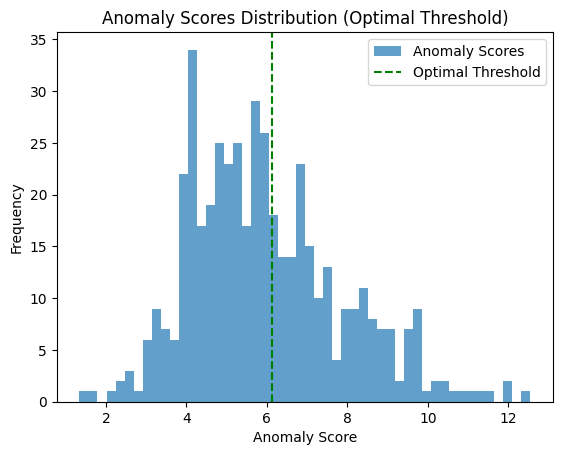

In [ ]:
# Evaluate performance
pred_labels = [1 if score > threshold else 0 for score in anomaly_scores]
true_labels = diseased_data.obs['disease'].map({'normal': 0, 'tumor': 1}).astype(int)

precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, anomaly_scores)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {roc_auc:.4f}")

# Visualization of anomaly scores
plt.hist(anomaly_scores, bins=50, alpha=0.7, label='Anomaly Scores')
plt.axvline(threshold, color='green', linestyle='--', label='Optimal Threshold')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Anomaly Scores Distribution (Optimal Threshold)')
plt.legend()
plt.show()

In [ ]:
for ds in datasets:
    print("LR scores shape:", ds.obsm['lr_scores'].shape)


LR scores shape: (2224, 550)
LR scores shape: (3037, 550)
LR scores shape: (2086, 550)


In [ ]:
# # Evaluation
true_labels = diseased_data.obs['disease'].map({'normal': 0, 'tumor': 1}).astype(int)
pred_labels = [1 if score > threshold else 0 for score in anomaly_scores]
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, anomaly_scores)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {roc_auc:.4f}")

Precision: 0.6150
Recall: 0.7188
F1 Score: 0.6628
AUC Score: 0.7832


In [ ]:
# Compute predicted labels based on the threshold
pred_labels = [1 if score > threshold else 0 for score in anomaly_scores]

# Save the predicted anomaly labels in the AnnData object
diseased_data.obs['anomaly_label'] = pred_labels

# Save the anomaly scores in the AnnData object (optional, for further analysis)
diseased_data.obs['anomaly_score'] = anomaly_scores

# Print confirmation
print("Predicted anomaly labels and scores saved in 'diseased_autocrine' AnnData object.")

Predicted anomaly labels and scores saved in 'diseased_autocrine' AnnData object.


In [ ]:
diseased_data.obs['anomaly_label'].value_counts()

,count
anomaly_label,
0,280
1,187


In [ ]:
import matplotlib.colors as mcolors

<Figure size 1200x600 with 0 Axes>

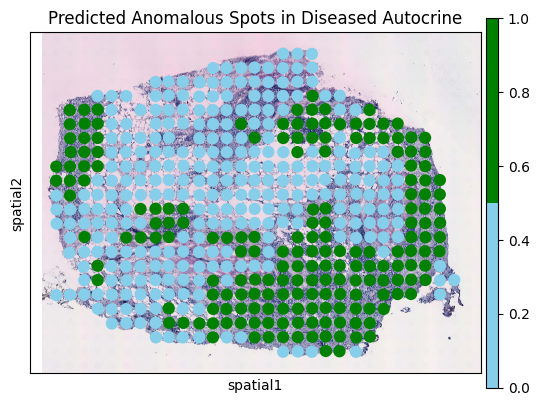

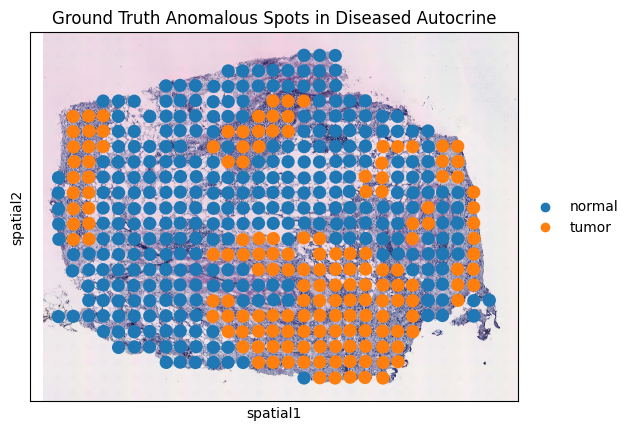

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a colormap for the visualizations
anomaly_cmap = mcolors.ListedColormap(['skyblue', 'green'])  # 'white' for normal, 'red' for anomalous

# Ground Truth Visualization
plt.figure(figsize=(12, 6))

# Predicted Anomalies Visualization
#plt.subplot(1, 2, 2)
sc.pl.spatial(
    diseased_data,
    color='anomaly_label',  # Column containing predicted anomalies
    size=5.0,
    cmap=anomaly_cmap,
    title="Predicted Anomalous Spots in Diseased Autocrine",
    show=False
)
sc.pl.spatial(
    diseased_data,
    color='disease',  # Ground truth column
    size=5.0,
    cmap=anomaly_cmap,
    title="Ground Truth Anomalous Spots in Diseased Autocrine",
    show=False
)

# # # Ground Truth Visualization
# plt.subplot(1, 2, 2)
# sc.pl.spatial(
#     diseased_autocrine,
#     color='COL1A1_ITGA11_binary_labels',  # Ground truth column
#     size=5.0,
#     cmap=anomaly_cmap,
#     title="Ground Truth Anomalous Spots in Diseased Autocrine",
#     show=False
# )

#plt.tight_layout()
plt.show()


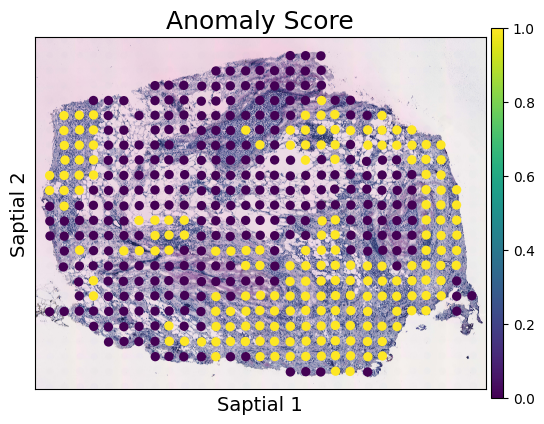

In [ ]:
ax = sc.pl.spatial(diseased_data, color=['anomaly_label'], s=90, show=False, crop_coord=(0, 8700, 800, 7600))
ax[0].set_title('Anomaly Score', fontsize=18)
ax[0].set_xlabel('Saptial 1', fontsize=14)
ax[0].set_ylabel('Saptial 2', fontsize=14)
plt.show()

[<Axes: title={'center': 'Ground Truth Anomalous Spots in Diseased Autocrine'}, xlabel='spatial1', ylabel='spatial2'>]

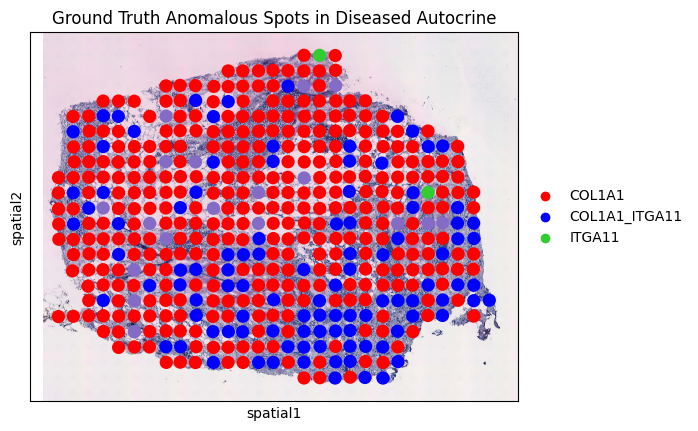

In [ ]:

sc.pl.spatial(
    diseased_autocrine,
    color='COL1A1_ITGA11_binary_labels',  # Ground truth column
    size=5.0,
    cmap=anomaly_cmap,
    title="Ground Truth Anomalous Spots in Diseased Autocrine",
    show=False
)